# Basic Bayesian Workflow

> This notebook provides an overview of the basic Bayesian workflow in PyMC 4
Note that model comparison seems broken in this version.

In [ ]:
#| default_exp bbw

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.test import *

In [ ]:
from aesara import pprint
from matplotlib import pyplot as plt, ticker
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pymc as pm
from aesara import tensor as at
import arviz as az
import xarray as xr

## Create model

### Simulate some data

In [ ]:
with pm.Model() as sim:
    x_dist = pm.Normal("x", 10, 1)
    ϵ_dist = pm.Normal("ϵ", 0, 1.5)

x_raw, ϵ = pm.draw([x_dist, ϵ_dist], 250)
y_raw = 5 + 3 * x_raw + ϵ

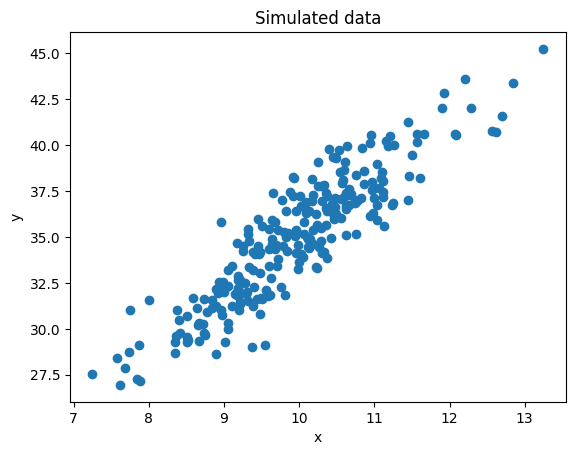

In [ ]:
plt.scatter(x_raw, y_raw)
plt.title("Simulated data")
plt.xlabel('x')
plt.ylabel('y')
plt.show();

### Scale data
Note that standardized data:

- Does not require an intercept
- Has a natural range for the regression slope

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
x_scaler, y_scaler = StandardScaler(), StandardScaler()

x = x_scaler.fit_transform(x_raw.reshape([-1,1])).squeeze()
y = y_scaler.fit_transform(y_raw.reshape([-1,1])).squeeze()

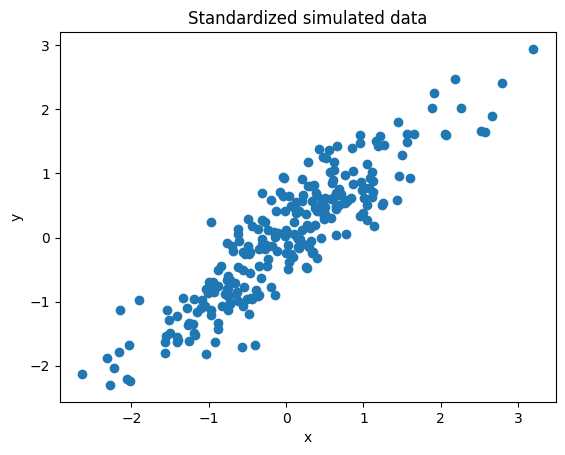

In [ ]:
plt.scatter(x, y)
plt.title("Standardized simulated data")
plt.xlabel('x')
plt.ylabel('y')
plt.show();

### Setup model
Note that due to the \beta prior this a regularized model.

In [ ]:
def setup_model(x, y, intercept=True):
    model = pm.Model()

    with model:        
        if intercept: α = pm.Normal("α", 0, 1)
        else: α = 0
        
        β = pm.Normal("β", 0, 1)
        σ = pm.HalfNormal("σ", 1)
        
        μ = α + β * x
            
        obs = pm.Normal("obs", μ, σ, observed=y)
        
    return model

model = setup_model(x, y, True)

### Visualise model

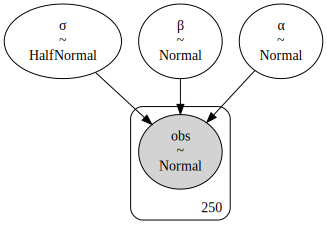

In [ ]:
pm.model_to_graphviz(model)

### Check priors parameters

In [ ]:
prior_samples = pm.sample_prior_predictive(samples=100, var_names=['α', 'β', 'σ', 'obs'], model=model)

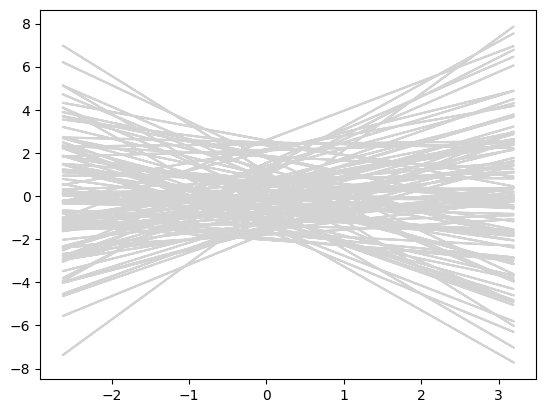

In [ ]:
for idx, row in prior_samples.prior.to_dataframe().iterrows():
    α = row['α']
    β = row['β']
    plt.plot(x, α + β * x, c='lightgrey')

### Check prior predictive

Text(0.5, 1.0, 'Historgram of observed and simulated target')

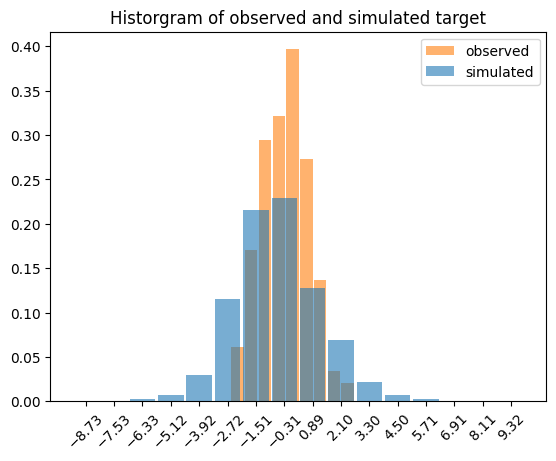

In [ ]:
az.plot_dist(
    y,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)

az.plot_dist(
    prior_samples.prior_predictive["obs"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

plt.title('Historgram of observed and simulated target')

## Fit model

### Sample using NUTS

In [ ]:
with model:
    #model_idata = pm.sample()
    model_trace = pm.sample(return_inferencedata=False)
    model_idata = pm.to_inference_data(trace=model_trace, model=model, log_likelihood=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


### Verify model

#### Summary

In [ ]:
az.summary(model_idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.00,0.03,-0.06,0.05,0.0,0.0,5933.97,3118.52,1.0
β,0.90,0.03,0.85,0.95,0.0,0.0,5774.87,3143.23,1.0
σ,0.43,0.02,0.40,0.47,0.0,0.0,5548.62,2994.59,1.0


#### Verify parameter sampling

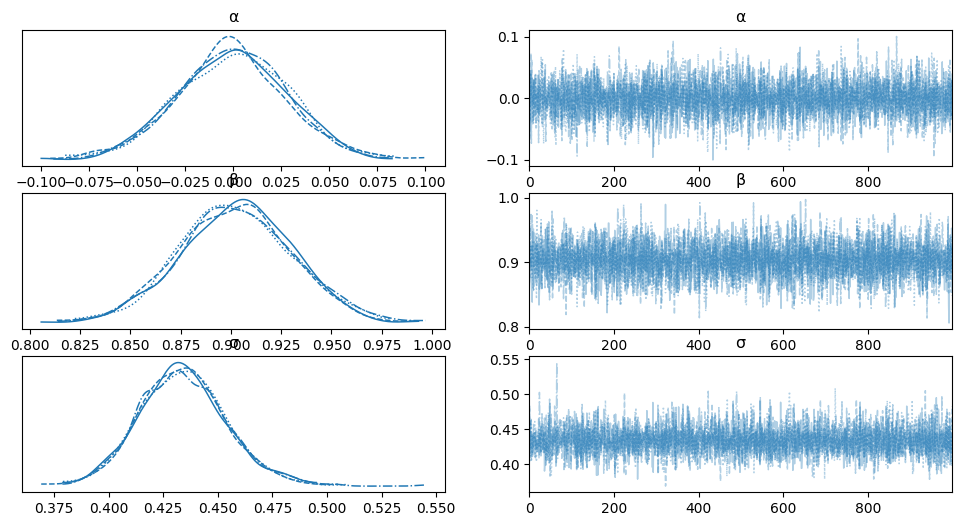

In [ ]:
az.plot_trace(model_idata);

#### Verify posterior label sampling

/home/sanne/.virtualenvs/pymc/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/sanne/.virtualenvs/pymc/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


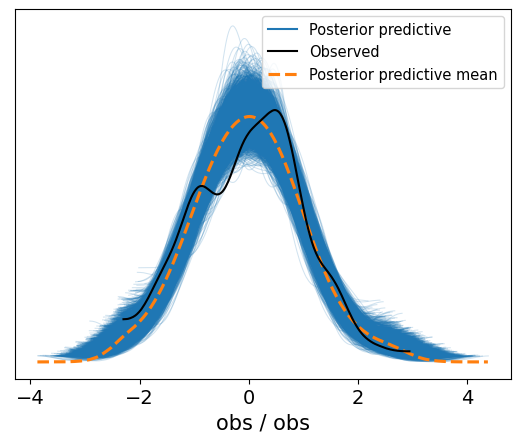

In [ ]:
# Note works if only posterior predictive y_hat is in sample
model_posterior_sample = pm.sample_posterior_predictive(model_idata, model=model)
az.plot_ppc(model_posterior_sample);

#### Plot HDI intervals

In [ ]:
posterior = model_idata.posterior
model_obs = (posterior["α"] + np.random.normal(0, posterior["σ"]) + posterior["β"] * xr.DataArray(x))
model_mu = (posterior["α"] + posterior["β"] * xr.DataArray(x))
avg_model_mu = model_mu.mean(dim=['chain', 'draw'])

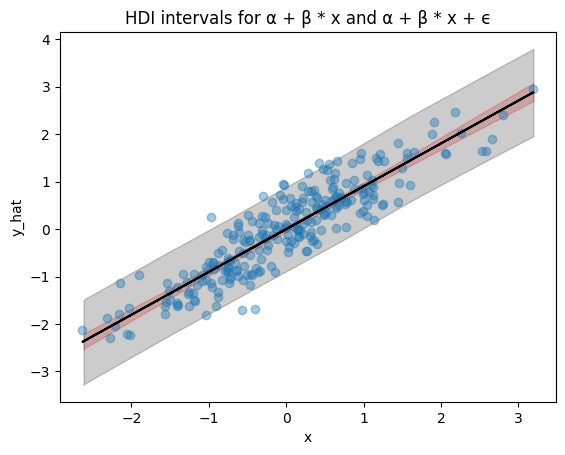

In [ ]:
az.plot_hdi(x, model_mu, hdi_prob=.96, color='r', fill_kwargs={"alpha": .2})
az.plot_hdi(x, model_obs, hdi_prob=.96, color='black', fill_kwargs={"alpha": .2})
plt.scatter(x, y, alpha=0.4)
plt.plot(x, avg_model_mu, color='black')
plt.xlabel('x')
plt.ylabel('y_hat')
plt.title('HDI intervals for α + β * x and α + β * x + ϵ');

#### Assess model fit

In [ ]:
az.waic(model_idata)

Computed from 4000 posterior samples and 250 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -146.70    10.87
p_waic        2.87        -

### Interpret results

#### Plot forest

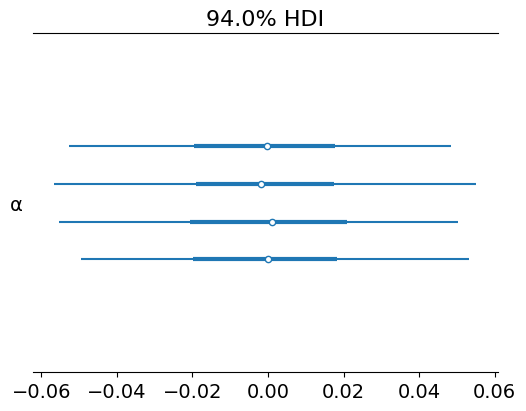

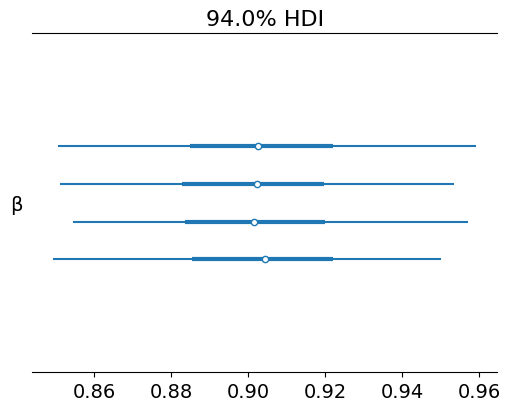

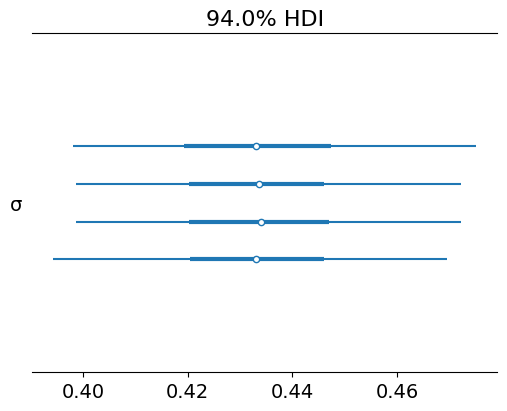

In [ ]:
for var_name in ['α', 'β', 'σ']:
    az.plot_forest(model_idata, var_names=var_name);

#### Plot HDI for parameters

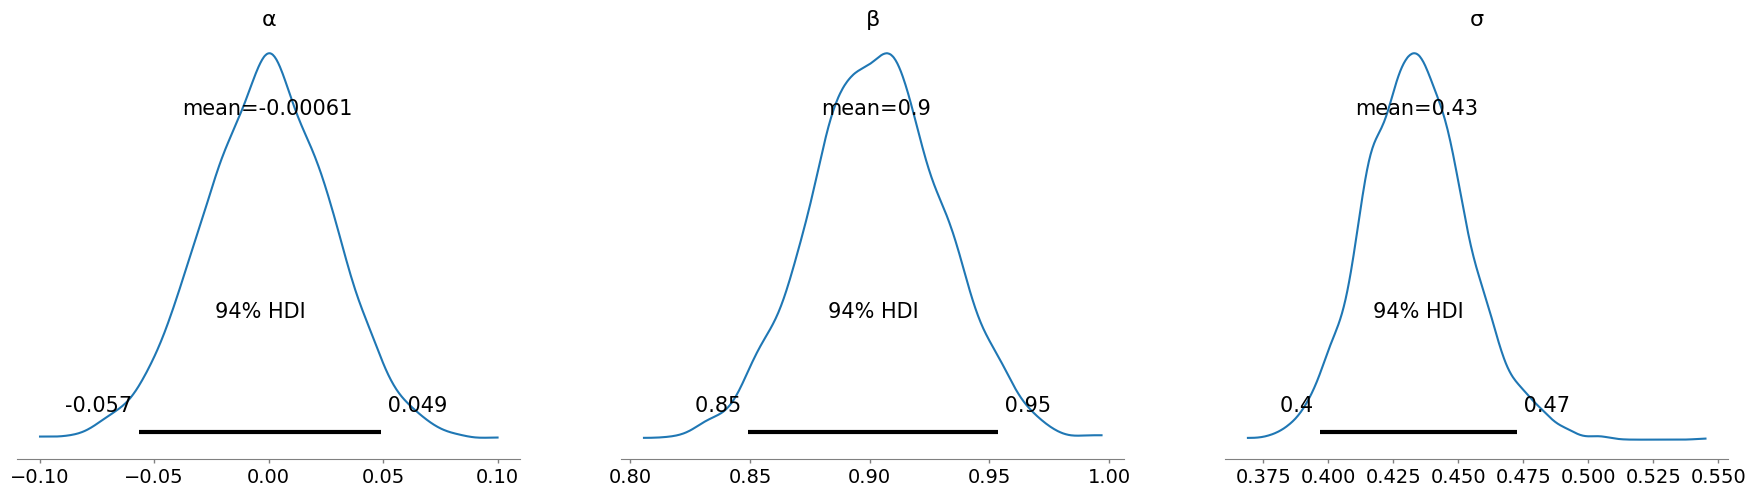

In [ ]:
az.plot_posterior(model_idata);

## Compare with better model

### Create better model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


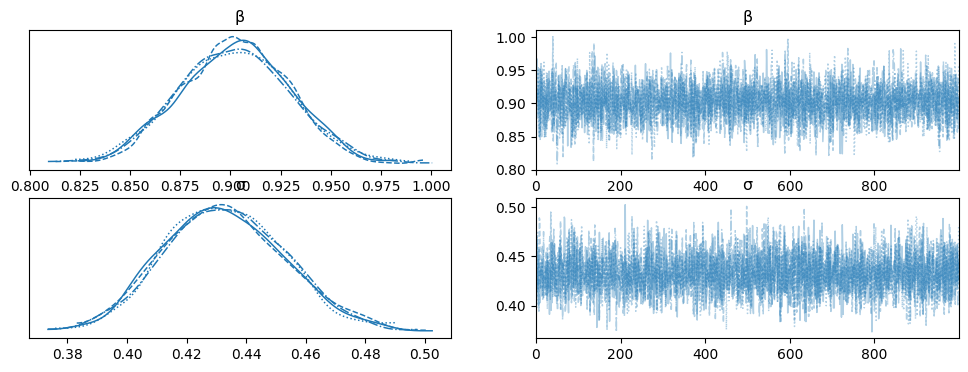

In [ ]:
better_model = setup_model(x, y, False)

with better_model:
    better_model_idata = pm.sample()    

az.plot_trace(better_model_idata);

In [ ]:
az.waic(better_model_idata)

Computed from 4000 posterior samples and 250 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -145.66    10.89
p_waic        1.85        -

### Compare the fit

In [ ]:
# df_comp_loo = az.compare({
#     "model": model_idata,
#     "better_model": better_model_idata
# })

# df_comp_loo

In [ ]:
# Plot loo or WAICC with dloo or dWAIC
#az.plot_compare(df_comp_loo, insample_dev=False);

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()